# 4.1 Preprocessing and Exploratory Data Analysis

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
dataset =  "train_data(in).csv"
df = pd.read_csv(dataset)
df.head()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,0x1f91d2d3ff8ce66dd75ab221f370c71c431dd659,1,333.22,1836.33,157384.67,66,0.018293,1.609584,0.264718,0.009007,0.335513,134,19.853878,0.058596
1,0x4684d57d2fe38b7990d6d82760922da0928e4eda,1,0.00,269.50,206082.30,10,0.088038,2.030283,0.790670,7.905838,7.905838,11,7.906699,0.000861
2,0x570208193f67c138ba3dd60a3aee9b0fa9d574c2,0,6180.19,3503.34,551924.28,14,0.002108,15.000000,3.704406,0.000000,1.856308,101,100.018959,-37.347870
3,0x5ffc014343cd971b7eb70732021e26c35b744cc4,0,0.00,47.60,475945.68,4594,0.000000,0.103400,0.000069,0.000000,0.000000,10000,0.692556,0.692556
4,0x6ce81b6206a73dc33f7635942905fdb3fd1e21bf,0,0.00,1955.01,226781.43,3,0.000000,0.463344,0.233199,0.000000,0.000000,117,27.051093,27.051093


Remove unnecessary columns: 'Address'

In [6]:
df_cleaned = df.drop(columns=['Address'])

Handling Missing Values

In [7]:
df_cleaned.isnull().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Unique Received From Addresses                          0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
avg val sent                                            0
total transactions (including tnx to create contract    0
total ether received                                    0
total ether balance                                     0
dtype: int64

In [8]:
from sklearn.preprocessing import MinMaxScaler

df_cleaned = df.drop(columns=['Address']) 
X = df_cleaned.drop(columns=['FLAG']) 
y = df_cleaned['FLAG'] 

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

df_scaled = pd.concat([X_scaled_df, y.reset_index(drop=True)], axis=1)

print(df_scaled.head()) 

   Avg min between sent tnx  Avg min between received tnx   
0                  0.000228                      0.003551  \
1                  0.000000                      0.000521   
2                  0.004229                      0.006774   
3                  0.000000                      0.000092   
4                  0.000000                      0.003780   

   Time Diff between first and last (Mins)  Unique Received From Addresses   
0                                 0.055467                        0.006601  \
1                                 0.072629                        0.001000   
2                                 0.194513                        0.001400   
3                                 0.167736                        0.459446   
4                                 0.079924                        0.000300   

   min value received  max value received   avg val received  min val sent   
0        7.164285e-07         2.633905e-06      1.036745e-05  7.506192e-07  \
1       

Correlation Matrix

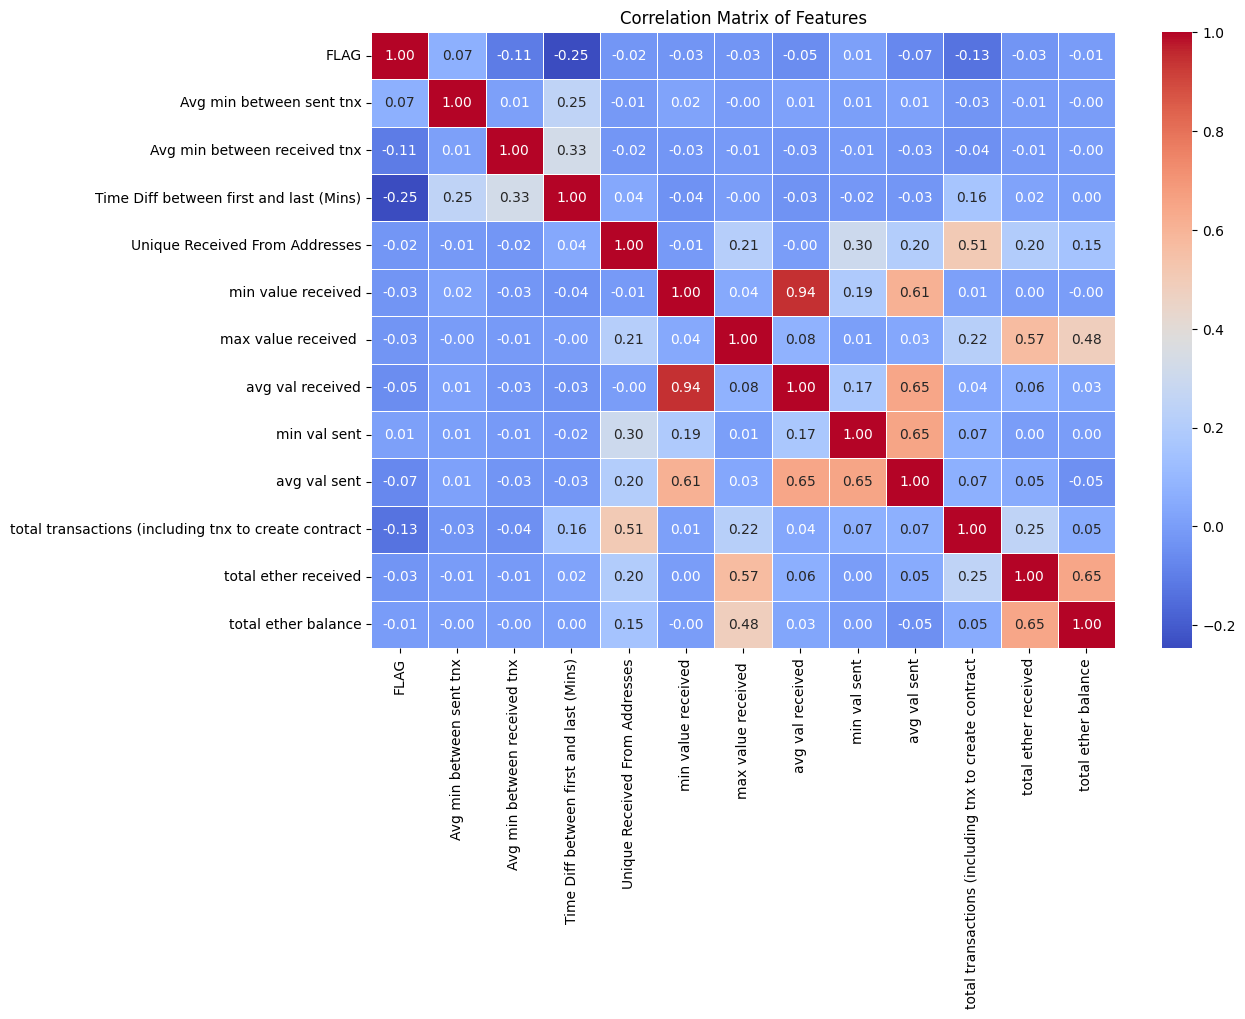

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

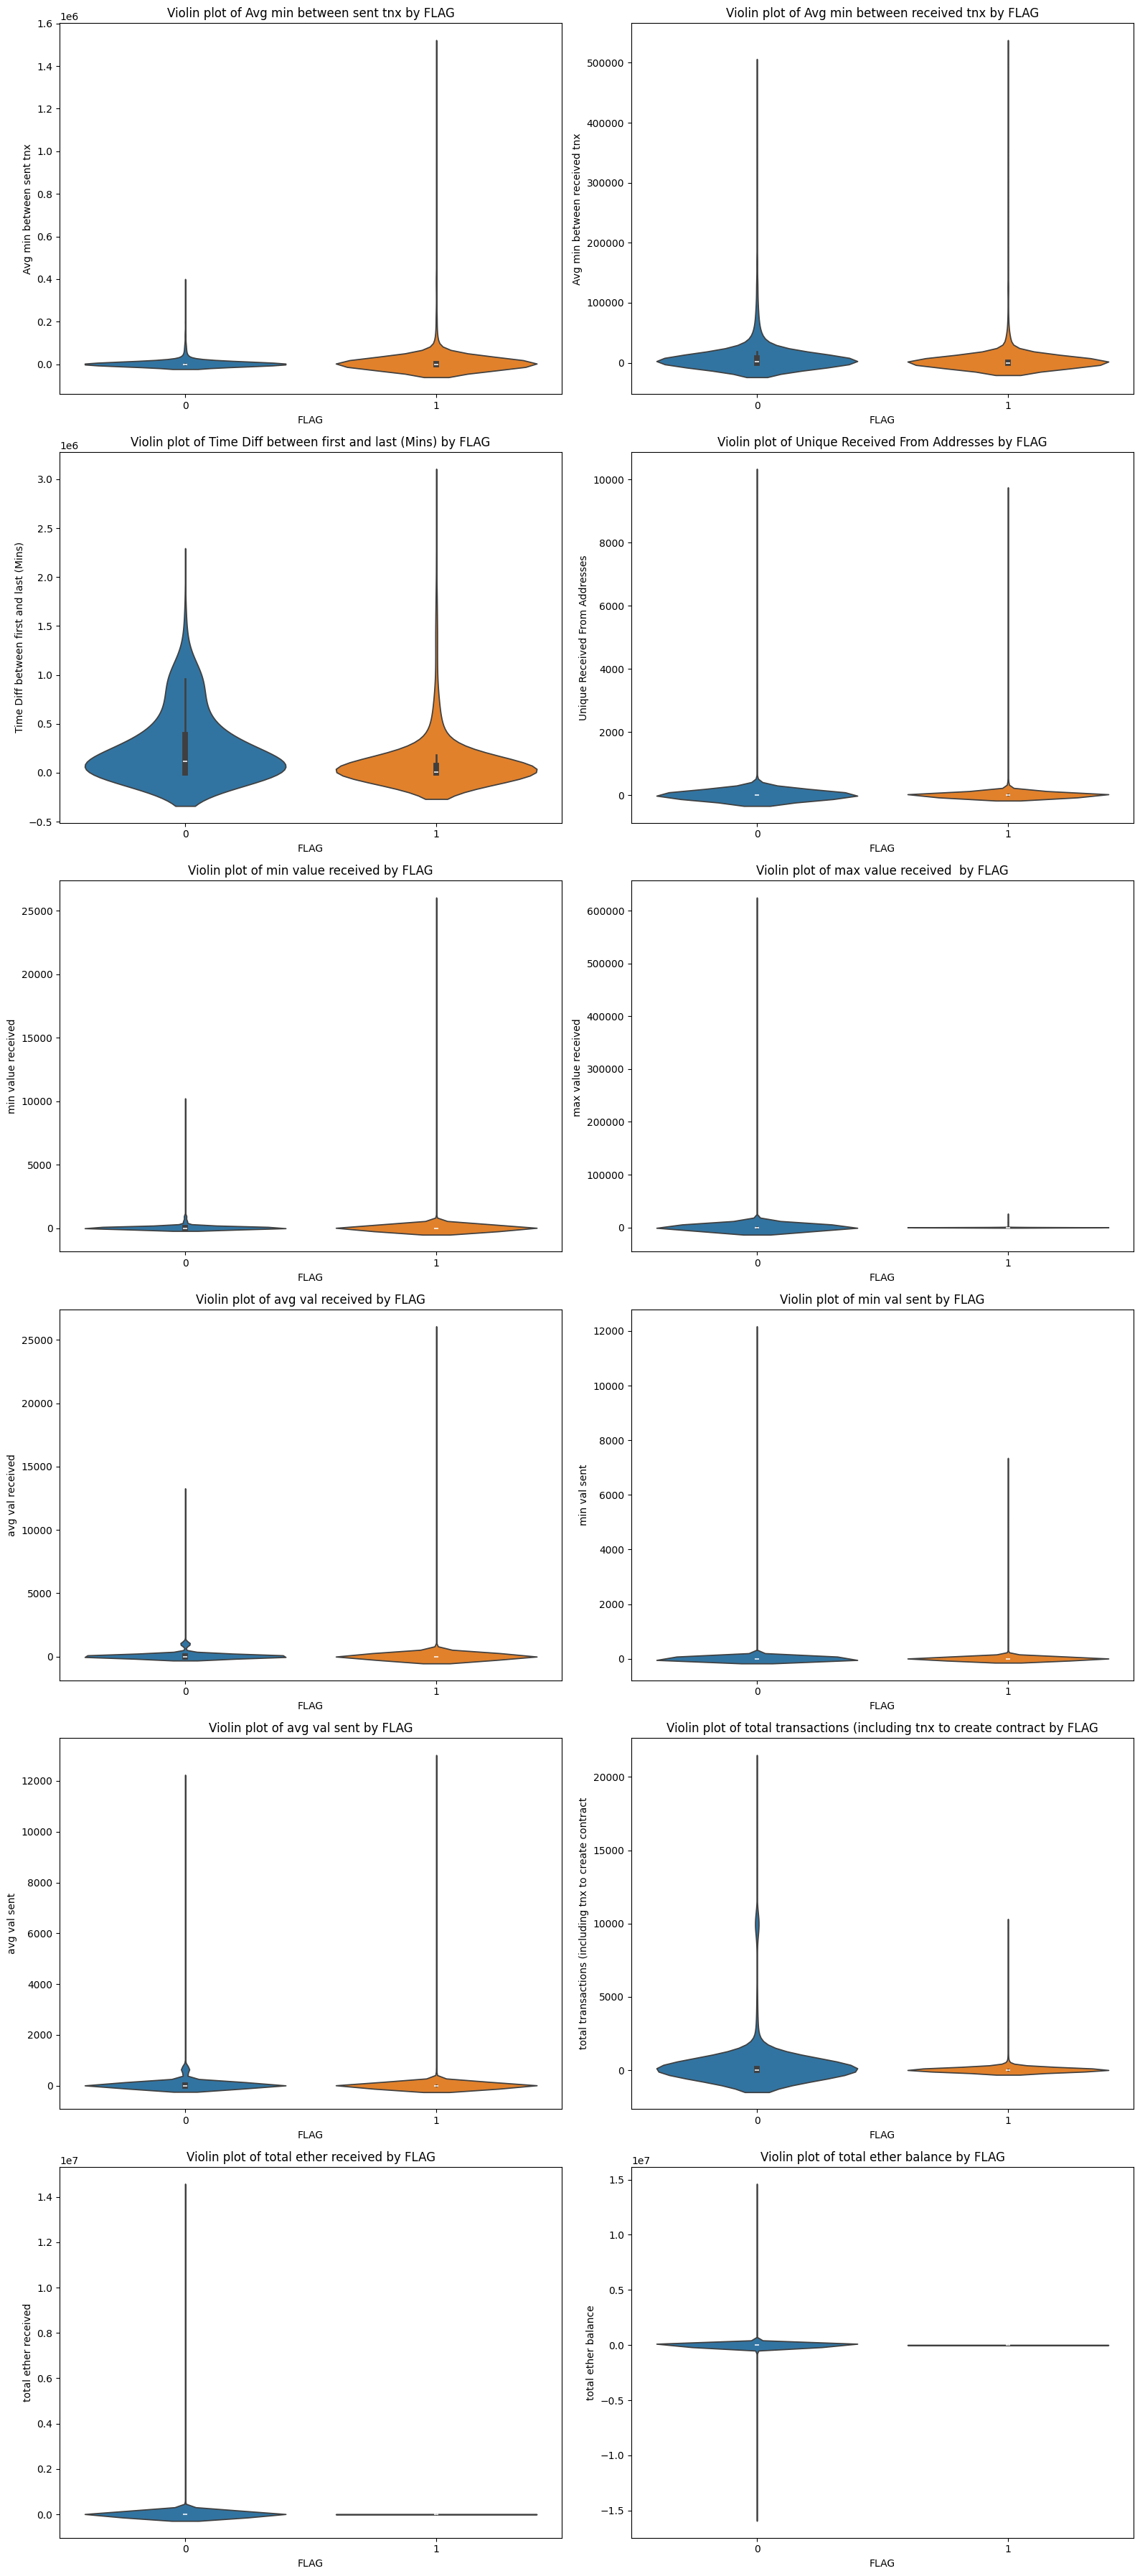

In [9]:
columns_to_plot = df_cleaned.columns.drop('FLAG')
num_cols = 2
fig, axes = plt.subplots(nrows=len(columns_to_plot) // num_cols + (len(columns_to_plot) % num_cols > 0),
                         ncols=num_cols,
                         figsize=(16, len(columns_to_plot) * 3))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.violinplot(ax=axes[i], x='FLAG', y=column, data=df_cleaned,hue='FLAG', legend=False,bw_method=0.5)
    axes[i].set_title(f"Violin plot of {column} by FLAG")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# 4.2 Fraud Detection Model

In [10]:
import numpy as np

class DecisionTree:
  def __init__(self, max_depth=None, min_samples_split=2, criterion="gini"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.tree = None

  def fit(self,X,Y):
    self.tree = self._build_tree(X, Y, depth=0)

  def predict(self,X):
    return np.array([self._predict_sample(x, self.tree) for x in X])

  def _gini(self, y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return 1 - np.sum(probs ** 2)

  def _entropy(self, y):
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    return -np.sum(probs * np.log2(probs + 1e-9))

  def _information_gain(self, parent, left, right):

    weight_left = len(left) / len(parent)
    weight_right = len(right) / len(parent)

    if self.criterion == "gini":
        gain = self._gini(parent) - (
            weight_left * self._gini(left) + weight_right * self._gini(right)
        )
    elif self.criterion == "entropy":
        gain = self._entropy(parent) - (
            weight_left * self._entropy(left) + weight_right * self._entropy(right)
        )
    return gain

  def _find_best_split(self, X, Y):
    best_split = {"gain": 0}
    n_samples, n_features = X.shape

    for feature in range(n_features):
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            left_idx = np.where(X[:, feature] <= threshold)[0]
            right_idx = np.where(X[:, feature] > threshold)[0]

            if len(left_idx) == 0 or len(right_idx) == 0:
                continue

            gain = self._information_gain(Y, Y[left_idx], Y[right_idx])
            if gain > best_split["gain"]:
                best_split = {
                    "gain": gain,
                    "feature": feature,
                    "threshold": threshold,
                    "indices": (left_idx, right_idx),
                }
    return best_split

  def _build_tree(self,X,Y,depth):
    if len(np.unique(Y)) == 1 or len(Y) < self.min_samples_split or (self.max_depth and depth >= self.max_depth):
        return {"type": "leaf", "class": self._most_common_label(Y)}

    best_split = self._find_best_split(X, Y)
    if best_split["gain"] == 0:
        return {"type": "leaf", "class": self._most_common_label(Y)}

    left_idx, right_idx = best_split["indices"]
    left_tree = self._build_tree(X[left_idx], Y[left_idx], depth + 1)
    right_tree = self._build_tree(X[right_idx], Y[right_idx], depth + 1)

    return {
            "type": "node",
            "feature": best_split["feature"],
            "threshold": best_split["threshold"],
            "left": left_tree,
            "right": right_tree,

     }

  def _most_common_label(self, y):
        return np.bincount(y).argmax()

  def _predict_sample(self, x, tree):
        if tree["type"] == "leaf":
            return tree["class"]
        if x[tree["feature"]] <= tree["threshold"]:
            return self._predict_sample(x, tree["left"])
        else:
            return self._predict_sample(x, tree["right"])

  
  def _calculate_feature_importance(self, tree):
        feature_importance = {}

        def traverse(node):
            if node['type'] == 'leaf':
                return
            if node['feature'] not in feature_importance:
                feature_importance[node['feature']] = 0
            feature_importance[node['feature']] += 1

            traverse(node['left'])
            traverse(node['right'])

        traverse(tree)

        return feature_importance

  def get_feature_importance(self):
        return self._calculate_feature_importance(self.tree)



In [11]:
dataset_test = "test_data(in).csv"
df_test = pd.read_csv(dataset_test)
dataset_val = "val_data(in).csv"
df_val = pd.read_csv(dataset_val)

In [12]:
X_test = df_test.drop(columns=['FLAG', 'Address'])
y_test = df_test['FLAG']

X_val = df_val.drop(columns=['FLAG', 'Address'])
y_val = df_val['FLAG']

In [13]:
from sklearn.preprocessing import MinMaxScaler
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns) 
X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)  

In [14]:
X_train = df_scaled.drop(columns=['FLAG'])
y_train = df_cleaned['FLAG']

tree = DecisionTree(max_depth=5, min_samples_split=3, criterion="entropy")
tree.fit(X_train.values,  y_train.values) 

In [15]:
y_test_pred = tree.predict(X_test_scaled.values)

from sklearn.metrics import accuracy_score
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on the test data: {accuracy_test:.4f}")

y_val_pred = tree.predict(X_val_scaled.values)

accuracy_val = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on the validation data: {accuracy_val:.4f}")

Accuracy on the test data: 0.8520
Accuracy on the validation data: 0.8446


In [24]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
 
start_time_custom_train = time.time()
custom_tree = DecisionTree(max_depth=5, min_samples_split=3, criterion="entropy")
custom_tree.fit(X_train.values, y_train.values)
end_time_custom_train = time.time()

y_test_pred_custom = custom_tree.predict(X_test_scaled.values)
y_val_pred_custom = custom_tree.predict(X_val_scaled.values)

accuracy_test_custom = accuracy_score(y_test, y_test_pred_custom)
accuracy_val_custom = accuracy_score(y_val, y_val_pred_custom)

print(f"Custom Decision Tree - Accuracy on the test data: {accuracy_test_custom:.4f}")
print(f"Custom Decision Tree - Accuracy on the validation data: {accuracy_val_custom:.4f}")

training_time_custom = end_time_custom_train - start_time_custom_train
print(f"Training time for Custom Decision Tree model: {training_time_custom:.4f} seconds")
print("\n")

# Scikit-learn Decision Tree 
start_time_sklearn_train = time.time()
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=3, criterion="entropy")
sklearn_tree.fit(X_train, y_train) 
end_time_sklearn_train = time.time()

y_test_pred_sklearn = sklearn_tree.predict(X_test_scaled)
y_val_pred_sklearn = sklearn_tree.predict(X_val_scaled)

accuracy_test_sklearn = accuracy_score(y_test, y_test_pred_sklearn)
accuracy_val_sklearn = accuracy_score(y_val, y_val_pred_sklearn)

print(f"Scikit-learn Decision Tree - Accuracy on the test data: {accuracy_test_sklearn:.4f}")
print(f"Scikit-learn Decision Tree - Accuracy on the validation data: {accuracy_val_sklearn:.4f}")

training_time_sklearn = end_time_sklearn_train - start_time_sklearn_train
print(f"Training time for Scikit-learn model: {training_time_sklearn:.4f} seconds")

# Comparison 
print("\nComparison:")
print(f"Accuracy Difference (Test): {accuracy_test_sklearn - accuracy_test_custom:.4f}")
print(f"Accuracy Difference (Validation): {accuracy_val_sklearn - accuracy_val_custom:.4f}")
print(f"Training Time Difference: {training_time_sklearn - training_time_custom:.4f} seconds")


Custom Decision Tree - Accuracy on the test data: 0.8520
Custom Decision Tree - Accuracy on the validation data: 0.8446
Training time for Custom Decision Tree model: 53.9818 seconds


Scikit-learn Decision Tree - Accuracy on the test data: 0.8647
Scikit-learn Decision Tree - Accuracy on the validation data: 0.8459
Training time for Scikit-learn model: 0.0312 seconds

Comparison:
Accuracy Difference (Test): 0.0127
Accuracy Difference (Validation): 0.0013
Training Time Difference: -53.9506 seconds


# 4.3 Hyperparameter Tuning

Best hyperparameters:
max_depth                  10
min_samples_split           5
criterion                gini
accuracy             0.891832
Name: 18, dtype: object


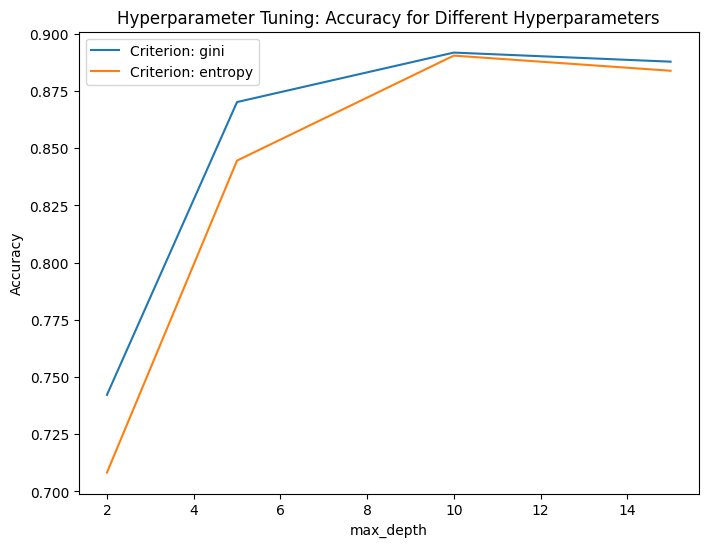

In [27]:
max_depth_values = [2,5,10,15]
min_samples_split_values = [2, 5, 10,15]
criterion_values = ['gini', 'entropy']

results = []

for max_depth in max_depth_values:
    for min_samples_split in min_samples_split_values:
        for criterion in criterion_values:
            tree = DecisionTree(max_depth=max_depth, min_samples_split=min_samples_split, criterion=criterion)
      
            tree.fit(X_train.values, y_train.values)
 
            y_val_pred = tree.predict(X_val_scaled.values)
            accuracy_val = accuracy_score(y_val, y_val_pred)
   
            results.append((max_depth, min_samples_split, criterion, accuracy_val))

results_df = pd.DataFrame(results, columns=['max_depth', 'min_samples_split', 'criterion', 'accuracy'])

best_combination = results_df.loc[results_df['accuracy'].idxmax()]
print("Best hyperparameters:")
print(best_combination)

# Plot
pivot_table = results_df.pivot_table(index='min_samples_split', columns='max_depth', values='accuracy', aggfunc=np.max)

plt.figure(figsize=(8, 6))
for criterion in criterion_values:
    subset = results_df[results_df['criterion'] == criterion]
    pivot_table = subset.pivot_table(index='min_samples_split', columns='max_depth', values='accuracy', aggfunc=np.max)
    plt.plot(pivot_table.columns, pivot_table.loc[5], label=f'Criterion: {criterion}')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Hyperparameter Tuning: Accuracy for Different Hyperparameters')
plt.legend()
plt.show()

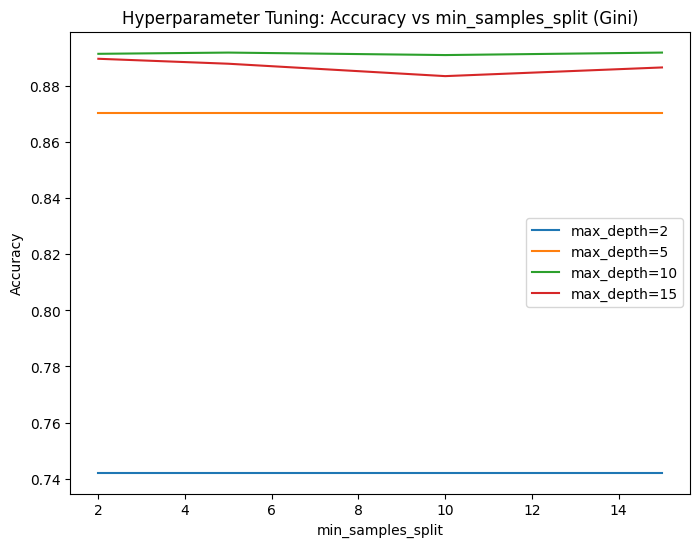

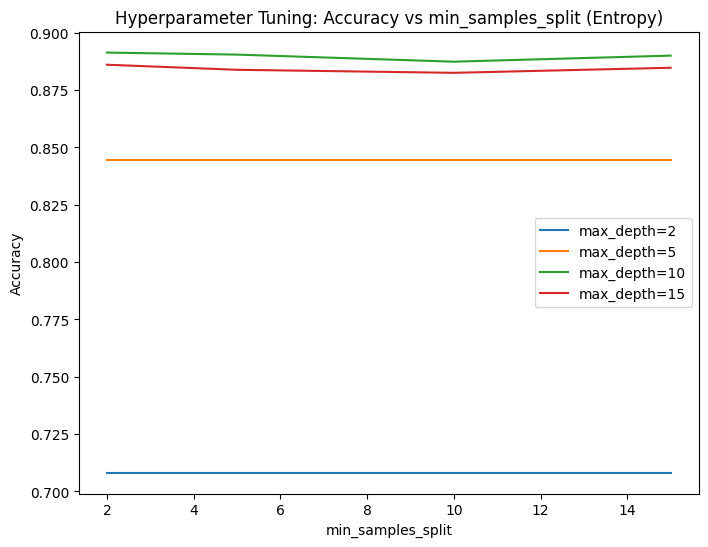

In [28]:
max_depth_values = [2,5,10,15]
min_samples_split_values = [2, 5, 10,15]
criterion_values = ['gini', 'entropy']

for criterion in criterion_values:
    plt.figure(figsize=(8, 6))
    for max_depth in max_depth_values:
        subset = results_df[(results_df['criterion'] == criterion) & (results_df['max_depth'] == max_depth)]
        plt.plot(subset['min_samples_split'], subset['accuracy'], label=f'max_depth={max_depth}')
    plt.xlabel('min_samples_split')
    plt.ylabel('Accuracy')
    plt.title(f'Hyperparameter Tuning: Accuracy vs min_samples_split ({criterion.capitalize()})')
    plt.legend()
    plt.show()

# 4.4 Model Visualization

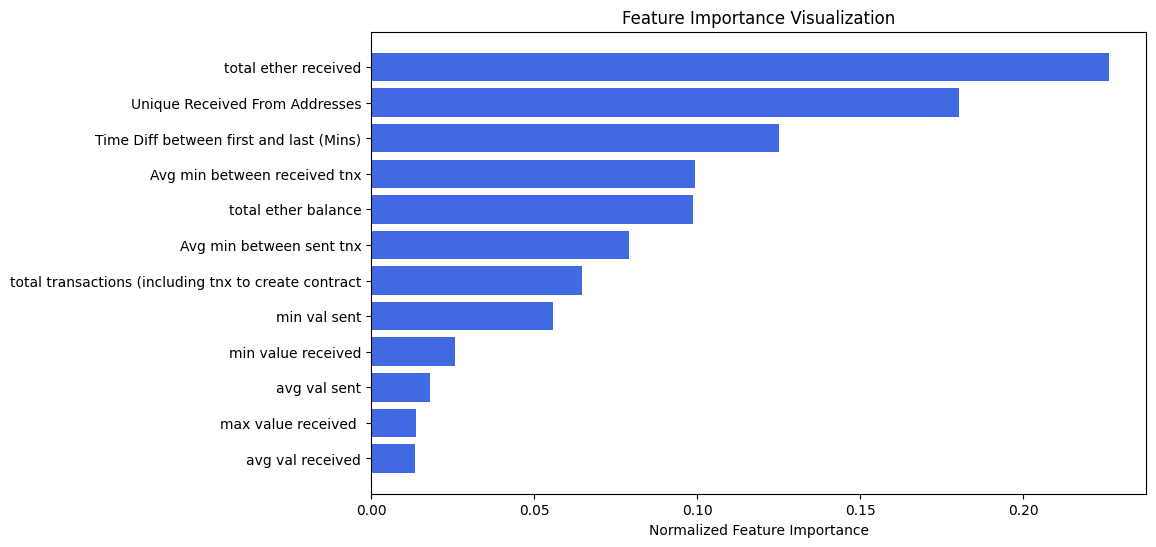

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_feature_importance(tree_structure):
    feature_importance = {}

    def traverse(node, path_importance=1):
        if node['type'] == 'leaf':
            return
        feature = node['feature']
        if feature not in feature_importance:
            feature_importance[feature] = 0
        feature_importance[feature] += path_importance 

        left_contrib = node.get('left_weight', 0.5)  
        right_contrib = node.get('right_weight', 0.5)

        traverse(node['left'], path_importance * left_contrib)
        traverse(node['right'], path_importance * right_contrib)

    traverse(tree_structure)

    total_importance = sum(feature_importance.values())
    for feature in feature_importance:
        feature_importance[feature] /= total_importance

    return feature_importance

def plot_feature_importance(feature_importance, feature_names):

    sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    sorted_features = [feature_names[int(k)] for k, _ in sorted_importance]
    sorted_values = [v for _, v in sorted_importance]

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_values, color='royalblue')
    plt.xlabel('Normalized Feature Importance')
    plt.title('Feature Importance Visualization')
    plt.gca().invert_yaxis()  
    plt.show()

tree = DecisionTree(max_depth=10,min_samples_split=5,criterion="gini")
tree.fit(X_train.values, y_train.values)

feature_importance = calculate_feature_importance(tree.tree)

plot_feature_importance(feature_importance, X_train.columns)


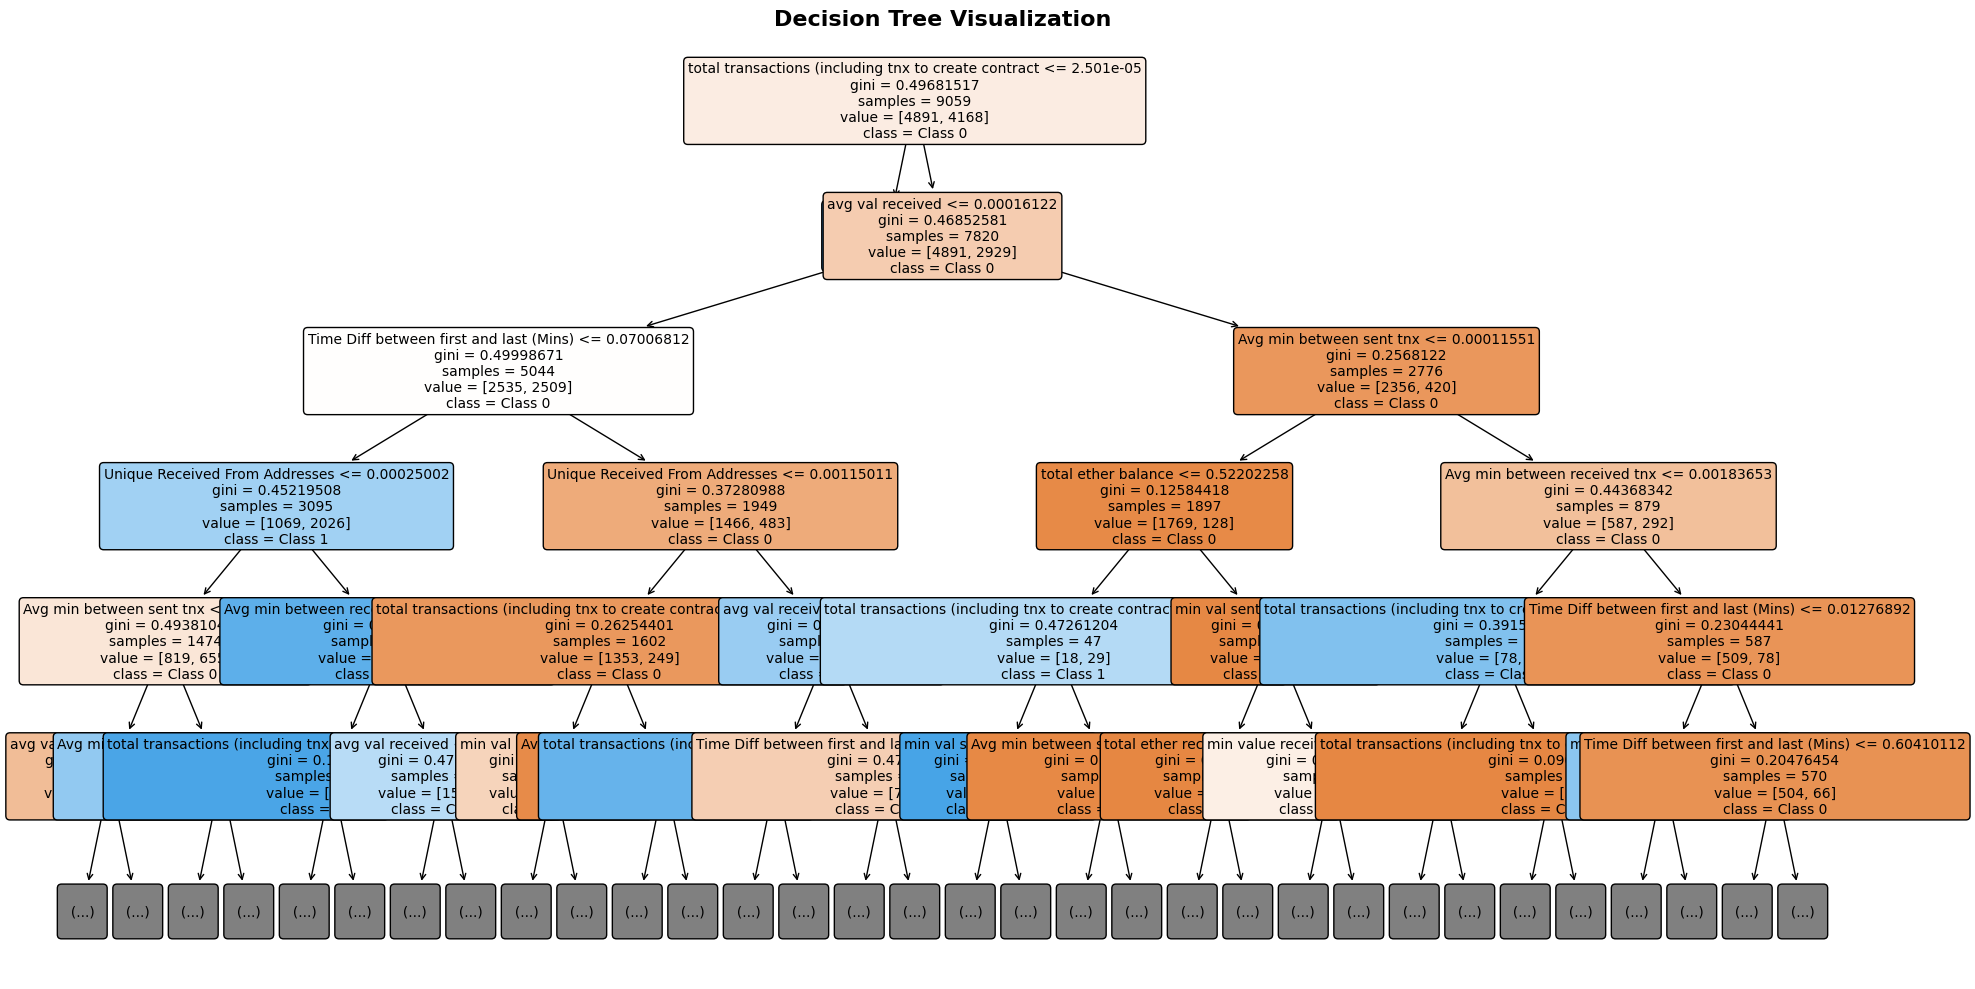

In [25]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

X_train = pd.DataFrame(X_train, columns=[
    "Avg min between sent tnx", 
    "Avg min between received tnx", 
    "Time Diff between first and last (Mins)", 
    "Unique Received From Addresses", 
    "min value received",
    "max value received", 
    "avg val received", 
    "min val sent", 
    "avg val sent", 
    "total transactions (including tnx to create contract",
    "total ether received", 
    "total ether balance"
])

X_train.columns = X_train.columns.str.strip()

features = X_train.columns.tolist()

X_train = X_train.to_numpy()
y_train = y_train.ravel()

tree = DecisionTree(max_depth=10, min_samples_split=5, criterion="gini")
tree.fit(X_train, y_train)

def visualize_tree_with_conditions(model, feature_names, class_names=None, max_depth=None):
    plt.figure(figsize=(20, 10))
    plot_tree(
        model,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=10,
        max_depth=max_depth,
        precision = 8,
        label='all'
    )
    plt.title("Decision Tree Visualization", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

visualize_tree_with_conditions(
    model=tree, 
    feature_names=features, 
    class_names=["Class 0", "Class 1"],  
    max_depth=5
)
